
# NLP: Predicciendo la polaridad de reseñas usando Deep Learning

La importancia de la satisfacción del cliente radica en que nos ayuda a saber la probabilidad de que un cliente haga una compra a futuro. Pedir a los clientes que califiquen el grado de satisfacción es una buena forma de ver si se convertirán en clientes habituales o incluso en defensores de la marca.

En el presente proyecto crearemos un modelo de Machine Learning que predica el número de estrellas que recibiría un producto con base en el comentario que haya dejado un cliente. Para ello utilizaremos el dataset de reseñas de Amazon en español. 

<div class="alert alert-warning">
<b>The Multilingual Amazon Reviews Corpus</b> <br>
Se puede acceder al dataset <a href="https://drive.google.com/uc?export=download&id=11XnXB7Ubgf3t6gotXGlM4FCwPOMHhDLX">aquí</a>. Es un comprimido .zip que contiene tres archivos .json. Más información sobre el dataset <a href="https://registry.opendata.aws/amazon-reviews-ml/">aquí</a>. Es importante que tengas en cuenta la <a href="https://docs.opendata.aws/amazon-reviews-ml/license.txt">licencia</a> de este dataset.
</div>

## 1. Preprocesado
### 1.1 Importaciones y configuración 

Importamos las librerías necesarias

In [ ]:
''' Data manipulation '''
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack

''' Visualization '''
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

''' NLP '''
import re
import nltk

''' Machine Learning '''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

'''Deep Learning '''
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.utils import plot_model
from plot_keras_history import plot_history

''' Misc '''
import sys, os, re, csv, codecs, gc
from time import time

Configuramos el estilo de los gráficos

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Palette
blue = '#146EF5'
red = '#ED3767'
amber = '#F5B14C'
mint = '#17BED1'
purple = '#815ADB'
pink = '#FE90AD'

# Cualitative colormap
palette = [blue, red, pink, purple, amber, mint]

# Sequential colormap
bluemint = LinearSegmentedColormap.from_list("myBlues", [mint, blue])
redpink = LinearSegmentedColormap.from_list("myReds", [pink, red])
redwhite = LinearSegmentedColormap.from_list("myReds", ['white', red])
bluewhite = LinearSegmentedColormap.from_list("myReds", ['white', blue])

# Diverging colormap
bluered = LinearSegmentedColormap.from_list("myBlueRed", [red, "white", blue])
blupurred = LinearSegmentedColormap.from_list("myBlueRed", [red, purple, blue])
rainbow = LinearSegmentedColormap.from_list("myBlueRed", [pink, red, purple, blue, mint])

params = {'axes.edgecolor': '0.9', 'axes.labelcolor': '0.4',
          'text.color': '0.3', 'xtick.color': '0.5', 'ytick.color': '0.5',
          'font.size': 16, 'axes.titlesize': 16, 'axes.labelsize': 12,
          'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'figure.figsize': (9, 6), 'axes.spines.right': False, 'axes.spines.top': False}

sns.set(context='notebook', style='white', palette=palette, rc=params)

### 1.2 Carga de datos y preprocesamiento

Cargamos los datos

In [ ]:
train = pd.read_csv('/work/processed_data/train.csv')
dev = pd.read_csv('/work/processed_data/dev.csv')
test = pd.read_csv('/work/processed_data/test.csv')

In [ ]:
X_train = train[['full_text', 'clean_text']].copy()
X_dev = dev[['full_text', 'clean_text']].copy()
X_test = test[['full_text', 'clean_text']].copy()

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=100, dtype=np.float32)

train_ngrams =  vectorizer.fit_transform(X_train['clean_text'])
dev_ngrams = vectorizer.transform(X_dev['clean_text'])
test_ngrams = vectorizer.transform(X_test['clean_text'])

# Obtenemos los nombres de las features
features_ngrams = np.array(vectorizer.get_feature_names())

Ahora extraemos las features indirectas:
mean_word_len,
count_stopwords,
word_unique_percent,
count_word, count_letters,
count_unique_word.

In [ ]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_indirect = pd.DataFrame()
train_indirect['count_word'] = X_train['full_text'].apply(lambda x: len(str(x).split()))
train_indirect['count_letters'] = X_train['full_text'].apply(lambda x: len(str(x)))
train_indirect['count_unique_word'] = X_train['full_text'].apply(lambda x: len(set(str(x).split())))
train_indirect["count_stopwords"] = X_train["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
train_indirect["mean_word_len"] = X_train["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
train_indirect['word_unique_percent'] = train_indirect['count_unique_word']*100/train_indirect['count_word']

In [ ]:
dev_indirect = pd.DataFrame()
dev_indirect['count_word'] = X_dev['full_text'].apply(lambda x: len(str(x).split()))
dev_indirect['count_letters'] = X_dev['full_text'].apply(lambda x: len(str(x)))
dev_indirect['count_unique_word'] = X_dev['full_text'].apply(lambda x: len(set(str(x).split())))
dev_indirect["count_stopwords"] = X_dev["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
dev_indirect["mean_word_len"] = X_dev["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
dev_indirect['word_unique_percent'] = dev_indirect['count_unique_word']*100/dev_indirect['count_word']

In [ ]:
test_indirect = pd.DataFrame()
test_indirect['count_word'] = X_test['full_text'].apply(lambda x: len(str(x).split()))
test_indirect['count_letters'] = X_test['full_text'].apply(lambda x: len(str(x)))
test_indirect['count_unique_word'] = X_test['full_text'].apply(lambda x: len(set(str(x).split())))
test_indirect["count_stopwords"] = X_test["full_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopword_list]))
test_indirect["mean_word_len"] = X_test["full_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_indirect['word_unique_percent'] = test_indirect['count_unique_word']*100/test_indirect['count_word']

Leemos los datasets de polaridad

In [ ]:
train_polarity = pd.read_csv('/work/processed_data/train_polarity.csv')
dev_polarity = pd.read_csv('/work/processed_data/dev_polarity.csv')
test_polarity = pd.read_csv('/work/processed_data/test_polarity.csv')

Solo falta juntar todas las features en un matriz dispersa

In [ ]:
X_train = hstack((train_ngrams, train_indirect,  train_polarity)).tocsr()
X_dev = hstack((dev_ngrams, dev_indirect,  dev_polarity)).tocsr()
X_test = hstack((test_ngrams, test_indirect,  test_polarity)).tocsr()

## 2. Modelado 
El proyecto pasado explicamos que el problema requiere ser abordado como una tarea de clasificación binaria puesto que los datos no permiten obtener una gran exactitud al predecir 5 clases.
Por ello, ahora trataremos de mejorar el accuracy obtenido con Linear SVC (0.86 en el set de validación) con un arquitectura de redes neuronales.

### 2.1 Linear SVC (benchmark)
Predecimos manteniendo solo 2 clases: negativo y postivo (convirtiendo las reviews con 3 estrellas en _negativo_)

In [ ]:
def binarize(x):
    if x == 4 or x == 5:
        return 1
    else:
        return 0
    
y_train = train['stars'].apply(binarize)
y_dev = dev['stars'].apply(binarize)
y_test = test['stars'].apply(binarize)

In [ ]:
svc = LinearSVC(penalty='l2', dual=False, tol=1e-4, C=0.01)

svc.fit(X_train, y_train)

y_train_pred_svc = svc.predict(X_train)
y_dev_pred_svc = svc.predict(X_dev)
y_test_pred_svc = svc.predict(X_test)

print('Accuracy en el set de Train:', accuracy_score(y_train, y_train_pred_svc))
print('Accuracy en el set de Dev:', accuracy_score(y_dev, y_dev_pred_svc))
print('Accuracy en el set de Test:', accuracy_score(y_test, y_test_pred_svc), '<---')

Accuracy en el set de Train: 0.869985
Accuracy en el set de Dev: 0.869
Accuracy en el set de Test: 0.8646 <---


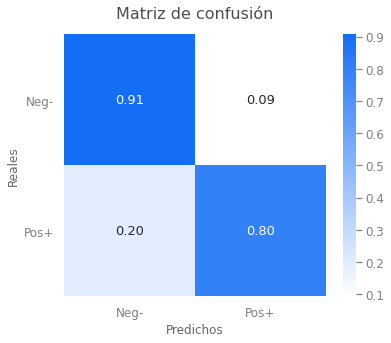

In [ ]:
plt.figure(figsize=(6, 5))
conf_sent = confusion_matrix(y_test, y_test_pred_svc, 
                             labels=[0, 1], 
                             normalize='true')
sns.heatmap(data = conf_sent, cbar=True, square=True, annot=True, 
            fmt= '.2f', annot_kws={'size': 13}, 
            xticklabels= ['Neg-', 'Pos+'], 
            yticklabels=['Neg-', 'Pos+'], 
            cmap=bluewhite)

plt.title('Matriz de confusión', pad=16)
plt.ylabel('Reales')
plt.xlabel('Predichos')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

#### 2.1.2 Neural Network

El enfoque que utilizaremos será crear una red neuronal usando la arquitecura LSTM, la que alimentaremos usando el texto limpio que ya
prepocesamos en el notebook del proyecto anterior.

In [ ]:
# Extraemos la lista de los comentarios para cada set
list_sentences_train = train['clean_text']
list_sentences_dev = dev['clean_text']
list_sentences_test = test['clean_text']

In [ ]:
d={1:'Neg', 2:'Neg', 3: 'Neg', 4:'Pos', 5:'Pos'}

#y_train = pd.get_dummies(train['stars'].apply(lambda x:d[x]))
#y_dev = pd.get_dummies(dev['stars'].apply(lambda x:d[x]))
#y_test = pd.get_dummies(test['stars'].apply(lambda x:d[x]))

Para transformar el corpus en números que la red pueda entender haremos esto: lo que vamos a hacer:

1. **Tokenización:** Necesitamos descomponer la frase en palabras únicas.
2. **Indexación:** Ponemos las palabras en una estructura similar a un diccionario y les damos un índice a cada una.
3. **Representación del índice:** Representamos la secuencia de palabras en los comentarios en forma de índice, y alimentar esta cadena de índices en nuestro LSTM.

In [ ]:
# Definimos el número máximo de features como 5000 porque fue la cantidad con mejores resultados
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_dev = tokenizer.texts_to_sequences(list_sentences_dev)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

Ahora visualizaremos la distribución de la longitud de los comentarios para poder definir una logitud máxima adecuada.

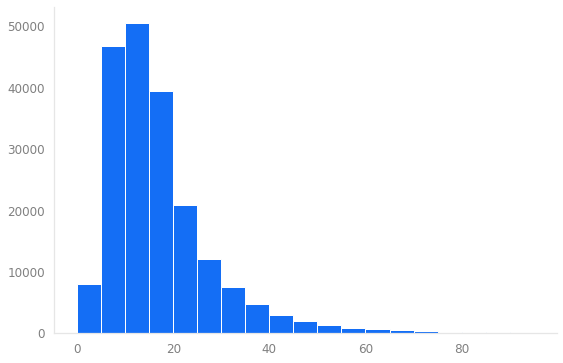

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,100,5))
plt.show()

Podemos observar que la mayoría de las reviews tiene menos de 50 tokens, así que podemos este número para tener un rago confiable y que no pierda información . 

In [ ]:
maxlen = 60
X_tr = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_de = pad_sequences(list_tokenized_dev, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

**Ahora empezamos a construir el modelo**

Esta es la arquitectura del modelo que estamos tratando de construir.

![](https://i.imgur.com/F8YyAym.png)


Definimos el capa input con el número máximos de dimensiones que definimos antes

In [ ]:
inp = Input(shape=(maxlen, )) #Dejamos el espacio en blanco despues de la coma para que Keras lo infiera

En nuestra capa de embedding 

In [ ]:
embed_size = 120
x = Embedding(max_features, embed_size)(inp)

A continuación alimentamos este Tensor a la capa del LSTM. Las arquitecturas basadas en redes neuronales 
recurrentes funcionan alimentando recursivamente el output de una red anterior en la entrada de la red actual, 
y tomarías la salida final después de X número de recursividad. 
Pero dependiendo del caso, se podría querer tomar las salidas de cada recursividad como resultado 
para pasar a la siguiente capa, como en este caso.

La capa de embedding nos proporciona un tensor 3D de (-, 50, 100) que usaremos dentro de la capa de LSTM. 
Que lo que hará será pasar a través de las muestras, ejecutar recursivamente el modelo LSTM durante 50 veces, 
pasando las coordenadas de las palabras cada vez. Y como queremos la versión desenrollada, 
recibiremos una tensor de shape (None, 50, 60), donde 60 es el número de secuencias que correra la capa de LSTM.

In [ ]:
x = LSTM(50, return_sequences=True, name='lstm_layer')(x)

Antes de que podamos pasar el output a una capa normal, necesitamos convertir el tensor 3D en uno 2D. 
Por lo tanto, usamos una capa de Global Max Pooling que normalmente se usa en problemas CNN para 
reducir la dimensionalidad de imagenes. Esta capa revisará cada pieza de datos, y
tomará los valores máximos de cada una. Y será esta colección de valores máximos nuestro
conjunto de datos que utilizares en las capas siguientes.

In [ ]:
x = GlobalMaxPool1D()(x)

Este Tensor 2D generado lo pasamos a una capa de Dropout que deshabilita arbitrariamente algunos nodos 
para que toda la red pueda resultar en una mejor generalización.

Configuramos un droput del 10%.

In [ ]:
x = Dropout(0.05)(x)

Después de una capa de dropout conectamos una capa densamente conectada y la salida pasa a través de 
una función RELU. Hemos definido la capa densa para producir una dimensión de salida de 50.

In [ ]:
x = Dense(20, activation="relu")(x)

Añadimos otra capa de dropout

In [ ]:
x = Dropout(0.05)(x)

Y, finalmente, el output los generará una capa con activación sigmoide para lograr una clasificación 
binaria(1,0) para cada una de las 2 etiquetas.

In [ ]:
x = Dense(1, activation="sigmoid")(x)

Solo queda definir las entradas, salidas y configurar el proceso de aprendizaje de la red. 
Hemos establecido nuestro modelo para optimizar nuestra función de pérdida usando 
el optimizador Adam, definiendo la función de pérdida como "binary_crossentropy" ya 
que estamos abordando una clasificación binaria.

In [ ]:
X_train_ = train_ngrams.toarray()
X_dev_ = dev_ngrams.toarray()
X_test_ = test_ngrams.toarray()

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
input_dim = X_train.shape[1]
print(input_dim)

4919


In [ ]:
#Defino la red neuronal
from keras.models import Sequential
from keras.regularizers import l2
model = Sequential()
model.add(layers.Dense(input_dim, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(2000, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dense(1000, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dense(100, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dense(10, input_dim=input_dim, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', 
              optimizer= 'sgd', 
              metrics=['accuracy'])

In [ ]:
#Entreno el modelo
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_dev, y_dev),
                    batch_size=100).history

InvalidArgumentError:  TypeError: 'SparseTensor' object is not subscriptable
Traceback (most recent call last):

  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/ops/script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 504, in py_method
    return [slice_array(inp) for inp in flat_inputs]

  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 504, in <listcomp>
    return [slice_array(inp) for inp in flat_inputs]

  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/data_adapter.py", line 503, in slice_array
    contiguous=contiguous)

  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_utils.py", line 53, in slice_arrays
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_utils.py", line 53, in <listcomp>
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

  File "/shared-libs/python3.7/py/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_utils.py", line 53, in <listcomp>
    entries = [[x[i:i + 1] for i in indices] for x in arrays]

TypeError: 'SparseTensor' object is not subscriptable


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_93845]

Function call stack:
train_function


In [ ]:
train_scores = model.evaluate(X_train, y_train, verbose=0)
print("Train loss:", train_scores[0])
print("Train accuracy:", train_scores[1],'\n')

test_scores = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

In [ ]:
#Grafico la pérdida y la exactitud de acuerdo a las épocas
plot_history(history)
plt.show()

In [ ]:
model = Model(inputs=inp, outputs=x)
history = model.compile(loss='binary_crossentropy',
                        optimizer='sgd',
                        metrics=['accuracy'])

Imprimimos un resumen del modelo

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 60, 120)           1200000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 60, 50)            34200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,234,251
Trainable params: 1,234,251
Non-trainable params: 0
_________________________________________________

Ahora corremos nuestro modelo

In [ ]:
batch_size = 100
epochs = 5
model.fit(X_tr, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
1800/1800 [==============================] - 139s 76ms/step - loss: 0.3938 - accuracy: 0.8176 - val_loss: 0.2462 - val_accuracy: 0.9216
Epoch 2/5
1800/1800 [==============================] - 137s 76ms/step - loss: 0.2854 - accuracy: 0.8794 - val_loss: 0.2464 - val_accuracy: 0.9222
Epoch 3/5
1800/1800 [==============================] - 137s 76ms/step - loss: 0.2548 - accuracy: 0.8947 - val_loss: 0.2323 - val_accuracy: 0.9248
Epoch 4/5
1800/1800 [==============================] - 137s 76ms/step - loss: 0.2315 - accuracy: 0.9055 - val_loss: 0.2520 - val_accuracy: 0.9110
Epoch 5/5
1800/1800 [==============================] - 137s 76ms/step - loss: 0.2111 - accuracy: 0.9147 - val_loss: 0.2379 - val_accuracy: 0.9215


In [ ]:
#Grafico la pérdida y la exactitud de acuerdo a las épocas
plot_history(history)
plt.show()

ValueError: Invalid history term of type <class 'NoneType'>

Hallamos las métricas para cada set

In [ ]:
#Calculo el accuracy y la pérdida para Train y Test
train_scores = model.evaluate(X_tr, y_train, verbose=0)
print("Train loss:", train_scores[0])
print("Train accuracy:", train_scores[1],'\n')

dev_scores = model.evaluate(X_de, y_dev, verbose=0)
print("Dev loss:", dev_scores[0])
print("Dev accuracy:", dev_scores[1],'\n')

test_scores = model.evaluate(X_te, y_test, verbose=0)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1], '<--')

Train loss: 0.18687909841537476
Train accuracy: 0.9286749958992004 

Dev loss: 0.3376915156841278
Dev accuracy: 0.8736000061035156 

Test loss: 0.3382907211780548
Test accuracy: 0.8690000176429749 <--
